In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

# run timestamp
ts = datetime.now().strftime('%Y%m%d_%H%M%S');

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/fashion_mnist_experiment/{ts}');

In [2]:
train_set = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False)

num_pixels = 28*28

# class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot');

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(num_pixels, 128)
        self.dropout = nn.Dropout(p = 0.3)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        # no softmax with CrossEntropyLoss - use NLLoss instead
        #return F.softmax(x, dim=1)
        return x

model = Net()
loss_func = nn.CrossEntropyLoss();

In [4]:
# HELPER FUNCTIONS

# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints with labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)    
    output = output.cpu()
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    
    images = images.cpu()
    
    # plot the images in the batch, along with predicted and true labels    
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

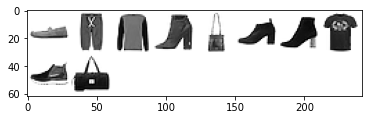

In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)
writer.add_graph(model, images)

# select random images and their target indices
images, labels = select_n_random(train_set.data, train_set.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels];

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for plots
loss_list = []
iteration_list = []
accuracy_list = []

running_loss = 0.0
for epoch in range(num_epochs):
    i = 0
    
    for data in train_loader:
        i += 1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # every 1000 mini-batches
        if not (i % 1000):
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            
            running_loss = 0.0

            
    with torch.no_grad():
        correct = 0
        
        for data in test_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)

            # forward
            outputs = model(inputs).cpu()
            
            # count correct
            correct += np.sum(np.equal(np.argmax(outputs, axis=1), labels).numpy())

        # record accuracy
        writer.add_scalar('accuracy',
                        correct / len(test_loader.dataset),
                        epoch+1)      

print('Finished Training')